In [41]:
import pandas as pd
import os
import numpy as np

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score 

In [75]:
#def getData():
#    cwd = os.getcwd()  #getting the path of this current program
#    filename = cwd + '/default of credit card clients.xls'  #path + file
    
np.random.seed(0)
#Read file into pandas dataframe 
nanDict= {}
df = pd.read_excel('default of credit card clients.xls', header=1, skiprows=0, index_col=0, na_values=nanDict)
df.rename(index=str, columns={'default payment next month': 'defaultPaymentNextMonth'}, inplace=True)

#Drop the rows including data where parameters are out of range
df=df.drop(df[df.SEX<1].index)
df=df.drop(df[df.SEX<2].index)
df=df.drop(df[(df.EDUCATION <1)].index)
df=df.drop(df[(df.EDUCATION >4)].index)
df=df.drop(df[df.MARRIAGE<1].index)
df=df.drop(df[df.MARRIAGE>3].index)

#Features and targets
#.values returns a numpy representation of the DataFrame
X= df.loc[:, df.columns != 'defaultPaymentNextMonth'].values 
y= df.loc[:, df.columns == 'defaultPaymentNextMonth'].values
    
# Categorical variables to one-hot's
onehotencoder = OneHotEncoder(categories="auto")

#OneHot encoder for column 1,2,3(,5,6,7,8,9,10)?? [sex,education,marriage, pay_april, pay_may, pay_jun, pay_jul, pay_aug, pay_sep]
#Designmatrix, hotencoder on the categorical columns
X = ColumnTransformer([('onehotencoder', onehotencoder, [1,2,3]),],remainder="passthrough").fit_transform(X)
y = np.ravel(y)
#return X, np.ravel(y)

In [ ]:
#train-test split
trainingShare = 0.8 
seed = 1
XTrain, XTest, yTrain, yTest=train_test_split(X, y, train_size=trainingShare,
                                              test_size = 1-trainingShare,
                                              random_state=seed)

# Input Scaling
sc     = StandardScaler()
XTrain = sc.fit_transform(XTrain)
XTest  = sc.transform(XTest)

Do we have to one-hot the target vector?

#One-hot's of the target vector
#Y_train_onehot, Y_test_onehot = onehotencoder.fit_transform(yTrain), onehotencoder.fit_transform(yTest)

## Exploring the balance of the output classes

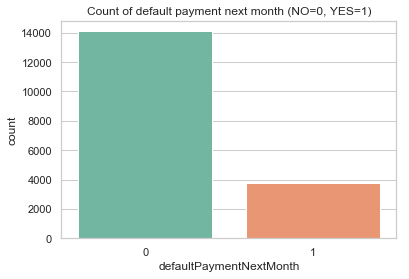

percentage of no default payment (NO=0) is 79.0310837300476
percentage of default payment (YES=1) is 20.968916269952395


In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
#plot
sns.set(style="white")
sns.set(style="whitegrid")
sns.countplot(x='defaultPaymentNextMonth',data=df, palette='Set2')
plt.title('Count of default payment next month (NO=0, YES=1)')
plt.savefig('counter_plot_y.png', dpi=300)
plt.show()

#percentage calculation 
count_no_default = len(df[df['defaultPaymentNextMonth']==0])
count_default = len(df[df['defaultPaymentNextMonth']==1])
pct_of_no_default = count_no_default/(count_no_sub+count_default)
print("percentage of no default payment (NO=0) is", pct_of_no_default*100)
pct_of_default = count_sub/(count_no_default+count_default)
print("percentage of default payment (YES=1) is", pct_of_default*100)

We see from the above presentation that out classes are imbalanced, as our ratio of no default vs default payment is 79:21. We may stumble on some complications regaridng this imbalance as it is hard to train an a model on an imbalanced data set. Therefore, we should consider finding a way of balancing these out. Can do so by multplying the 'YES=1' gradient by some default (79/21).


Or, use some other way of evaluating the accuracy of the model.

## Logistic Regression Model Fitting

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/Users/idunnmoatue/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/idunnmoatue/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [8]:
y_pred = logreg.predict(X_test)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.80


In [9]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      4284
           1       0.00      0.00      0.00      1073

    accuracy                           0.80      5357
   macro avg       0.40      0.50      0.44      5357
weighted avg       0.64      0.80      0.71      5357



## Neural Network
Testing full code for Neural Network, based on lecture notes 'Data Analysis and Machine Learning: Neural networks, from the simple perceptron to deep learning'

In [16]:
class NeuralNetwork:
    def __init__(self, X, y, n_hidden_neurons=50 , n_categories=10 , epochs=100 , batch_size=100 , eta=0.1 , lmbd=0.0):
        
        self.X = X
        self.y = y
        #self.X_full = self.X
        #self.y_full = self.y
        
        self.n_inputs         = X.shape[0]  #X-rows
        self.n_features       = X.shape[1]  #X-columns 
        self.n_hidden_neurons = n_hidden_neurons
        self.n_categories     = n_categories
        
        self.epochs           = epochs
        self.batch_size       = batch_size
        self.iterations       = self.n_inputs // self.batch_size #Floor division
        self.eta              = eta
        self.lmbd             = lmbd
        
        self.create_biases_and_weights() #gives the initial bias and weigths. 
        self.feed_forward()
        #print(self.hidden_weights)
        #print("***")
        self.backpropagation()
        #print(self.hidden_weights)        
            
    def sigmoid(self,x):
        return(1/(1 + np.exp(-x)))
        
    def create_biases_and_weights(self):
        self.hidden_weights = np.random.randn(self.n_features, self.n_hidden_neurons)
        self.hidden_bias    = np.zeros(self.n_hidden_neurons) + 0.01
        self.output_weights = np.random.randn(self.n_hidden_neurons, self.n_categories)
        self.output_bias    = np.zeros(self.n_categories) + 0.01
    
    def feed_forward(self):
        #feed_forward training
        self.z_h = np.matmul(self.X, self.hidden_weights) + self.hidden_bias
        self.a_h = self.sigmoid(self.z_h)
        
        self.z_o = np.matmul(self.a_h, self.output_weights) + self.output_bias
        
        exp_term = np.exp(self.z_o)
        self.probabilities = exp_term /np.sum(exp_term, axis=1, keepdims=True)
        
    
    def feed_forward_output(self, X):
        #feed_forward for output
        z_h = np.matmul(X, self.hidden_weights) + self.hidden_bias
        a_h = self.sigmoid(z_h)
        
        z_o = np.matmul(a_h, self.output_weights) + self.output_bias

        exp_term = np.exp(z_o)
        probabilities = exp_term/ np.sum(exp_term, axis=1, keepdims=True)
        return probabilities
    
    def backpropagation(self):
   
        error_output = self.probabilities - self.y  #Error in output layer delta^L
        error_hidden = np.matmul(error_output, self.output_weights.T) *self.a_h * (1-self.a_h) #Error for the jth neuron in lth layer delta^l
        
        self.output_weights_gradient = np.matmul(self.a_h.T, error_output)
        self.output_bias_gradient    = np.sum(error_output, axis=0)
        
        self.hidden_weights_gradient = np.matmul(self.X.T, error_hidden)
        self.hidden_bias_gradient    = np.sum(error_hidden, axis=0)
        
        
        if self.lmbd > 0.0:
            self.output_weights_gradient += self.lmbd * self.output_weights
            self.hidden_weights_gradient += self.lmbd * self.hidden_weights
            
        self.output_weights -= self.eta * self.output_weights_gradient
        self.output_bias    -= self.eta * self.output_bias_gradient
        self.hidden_weights -= self.eta * self.hidden_weights_gradient
        self.hidden_bias    -= self.eta * self.hidden_bias_gradient 
        
       
    
    
    def predict(self, X):
        probabilities = self.feed_forward_output(X)
        return np.argmax(probabilities, axis = 1)
    
    def predict_probabilities(self, X):
        probabilities = self.feed_forward_output(X)
        return probabilities
    
    
    
    #def train(self):
     #   data_ind = np.arange(self.n_inputs)
      #  print("hellu")
       # for i in range(self.epochs):
        #    for j in range(self.iterations):
                #pick datapoints with replacements
         #       chosen_datapoints = np.random.choice(data_ind, size=self.batch_size, replace=False)
                
                #minibatch training data
          #      self.X_full = self.X[chosen_datapoints]
           #     self.y_full = self.y[chosen_datapoints]
                
            #    self.feed_forward()
             #   self.backpropagation()
        
        
        
    
        
        
        
          
  
        
                

In [18]:
NN = NeuralNetwork( X, y, n_hidden_neurons=50, n_categories=10 , epochs=100 , batch_size=100 , eta=0.1 , lmbd=0.0)

NN.predict(X)


/Users/idunnmoatue/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


array([0, 0, 0, ..., 0, 0, 0])